(weighting_funs)=
# Weighting functions for temperature retrieval


Recall [Stull Chapter 8](https://www.eoas.ubc.ca/books/Practical_Meteorology/prmet102/Ch08-satellite_radar-v102b.pdf) Figure 8.4c (shown below).  As Stull explains a bunch of satellites use the 15 $\mu m$ CO2 absorption band
to look at the temperature at different heights in the atmosphere.  The key idea is that the changing density of
the atmosphere means that at any particular wavelength there is some level where most of the emittied atmospheric
photons originate from. If we know the vertical profile of dry air density and CO2 concentration, and the surface
temperature, we can measure those photons and back out an estimate of the air temperature for the emitting layer.

Key ideas:

1.  The Schwartzchild equation allows us to calculate the photon flux for a particular atmosphere and surface.  This
    is called the "forward model".

1.  CO2 is the ideal absorbing gas for this calculation, because its concentration is very well known, and it
    does not vary much with geographical location (because it takes so long to remove CO2 from the atmosphere, it
    is "well mixed"

1.  In theory, if we make 15 different radiance measurements at 15 different wavelengths in the CO2 absorption band,
    we should be able to invert the Schwartzchild equation for the temperature at 15 different heights.  In reality
    this is not possible, because the weighting functions for each wavelength overlap with height.

## Satellite radiance measured in the CO2 absorption band

### Transmisstance -- Stull Figure 8.4c

<img src="images/stull_8_4c.png" width=700>

It's a little hard to see in the figure, but there are 8 channels crunched between 13-15 microns, along the "shoulder" of the the main CO2 absorption band.

### Radiance and brightness temperature

The figure below is similar to Figure 8.4c, with the following differences:

1. The channel numbers are for an instrument called the VTPR (vertical temperature profiling radiometer), which has six channels indicated in the figure.

1. The horizontal axis is wavenumber = 1/wavelength.  That means that the plot goes from 500 $cm^{-1}$ (wavelength= 20 $\mu m$) on the left to 850 $cm^{-1}$ (wavelength = 12 $\mu m$) on the right, with the center at the center of the absorption band at wavenumber 666 $cm^{-1}$ (wavelength = 15 $\mu m$).

2. The y axis is the radiance (which they call intensity) reaching the satellite, also plotted as brightness temperature on the right axis.  While the transmission at 15 $\mu m$ (channel 1) is zero (black atmosphere) the emission is high in channel 1 because the emissivity is 1, and the stratosphere is hot.
That is, Channel 1 is at the center of the band -- it has the lowest transmissivity and is measuring photons coming from 45 km at the top of the stratosphere (See [Stull Chapter 1, Figure 1.10](https://www.eoas.ubc.ca/books/Practical_Meteorology/prmet101/Ch01-Atmos-v101.pdf)).

As the channel number increases from 2-6 the transmissivity also increases, and the photons originate from increasingly lower levels of the atmosphere with increasing kinetic temperatures.  Note the different heights for the peaks in each of the weighting functions.

<img src="images/wallace4_33.png" width=500>

### Weighting functions from Stull

<img src="images/stull_8_9.png" width=800>

## Calculating the weighting functions in the $CO_2$ 15 $\mu m$ absorption band

Recall that we've got two versions of the Schwartzchild equation in Schwartzchild notes:

Stull 8.4:

$$
         \begin{gathered}
           L_\lambda = B_\lambda(T_{skin}) \hat{t}_{\lambda,tot} + \sum_{j=1}^n
           B_\lambda(T_j) \Delta \hat{t}_{\lambda,j}
         \end{gathered}
$$

The calculus version derived in the notes:

$$
    L_\lambda(\tau_T)= B_\lambda(T_{skin}) \exp(-\tau_T) +    \int_0^{\tau_T} B_\lambda(T)\, d\hat{t}
$$

In either case, the crucial term is the differential transmissivity, $\Delta \hat{t}$ or $d \hat{t}$  which "weights"
the blackbody emission $B_\lambda(T)$ at a particular height.  The bigger the value of $d \hat{t}$, the bigger
the fraction of $B_\lambda(T)$ that is going to reach the satellite.

Below I show how to calculate the weight function in python.

### First get the optical depth from a sounding

This notebook uses the five standard atmospheres from  [hydrostatic_balance.ipynb](http://clouds.eos.ubc.ca/~phil/courses/atsc301/html/hydrostatic_balance.html) to show how to use Stull eq. 8.4 to calculate radiance at the top of the atmosphere for wavelengths similar to the 6 sounder channels shown in the above figure.  I define a new function **find_tau** to calculate the optical thickness for a $CO_2$-like absorbing gas, and get the weighting functions at 7 wavelengths from the transmission.   I then  plot the brightness temperatures at each wavelength for each of the five standard atmospheres.

We're going to need the air density as a function of height, so we'll require the **calcDensHeight**
function from the hydrostatic balance notebook, which I've moved to the a301.thermo library:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticks

#
# from the hydrostatic_balance notebook
#
import a301_lib
from sat_lib.thermo import calcDensHeight

******************************
context imported. Front of path:
/home/phil/work

in sat_lib init


I've also moved the csv file reader to the a301.utils.data_read module so we can
reuse tha code:

In [2]:
from sat_lib.utils.data_read import read_soundings

sound_dict = read_soundings()
print(list(sound_dict.keys()))

['subsummer', 'tropics', 'midsummer', 'midwinter', 'subwinter']


### Defining $k_\lambda$ and $\tau_\lambda$ for $CO_2$

I need values for the **mass absorption coefficient** $k_\lambda$ ($m^2/kg\ CO2$) defined in [Stull Chaper 2](https://www.eoas.ubc.ca/books/Practical_Meteorology/prmet102/Ch02-radiation-v102b.pdf) equation 2.31b.

$$
\hat{t} = \frac{E_{transmitted}}{E_{incident}} = -k_\lambda \rho_{co2} \Delta s
$$
where $\rho_{co2}$ is the density of CO2 and $\Delta s$ "slant path" i.e the distance the photons travel in the layer.  We can also
define the **mixing ratio** for CO2, which relates the CO2 density and the air density:

$$
r_{co2} = \frac{\rho_{co2}}{\rho_{air}}
$$

So that the transmissivity $\hat{t}$ can then be written:

$$
\hat{t} = \frac{E_{transmitted}}{E_{incident}} = -k_\lambda \rho_{co2} \Delta s = -k_\lambda r_{co2} \rho_{air} \Delta s
$$

Why is this a win?  Because for CO2 $r_{co2}$ is roughly constant with height -- the CO2 mixing ratio is about
$400 \times 10^{-6}$ CO2 molecules/air molecules almost everywhere.  That means that we just need to know
the air density $\rho_{air}$, which we can figure out from the ideal gas law as long as we have the pressure and temperature.

The  vertical optical depth is a special case where, instead of the **slant path** s through the atmosphere
we head straight up or down in the z direction.

In this case  $\tau$ is then defined by  (see the Beer's law notes):

$$
\frac{dE}{E} = -k_\lambda r_{co2} \rho_{air} dz = -d \tau_\lambda
$$

$$
\int_{E_{in}}^{E} \frac{dE^\prime}{E^\prime} = \int_0^z -k_\lambda r_{co2} \rho_{air} dz^\prime = \int_0^{\tau_\lambda} -d \tau_\lambda^\prime
$$

$$
\ln \frac{E}{E_{in}} = \int_0^z -k_\lambda r_{co2} \rho_{air} dz = - \tau_\lambda
$$

$$
E = E_{in} \exp( -\tau )
$$

where

$$\tau_\lambda = \int_0^z  r_{co2}\, \rho_{air}\, k_\lambda dz$$

Why is this an improvement?  We now have an absorption coefficient $k_\lambda$ and mixing ratio $r_{co2}$ that are roughly constant with height and can be taken out of the integral.  Everything is tied up neatly in the optical
depth $\tau_\lambda$, which is a kind of universal measure for the effect of absorption/scattering on the
incident radiation.  A pair of atmospheres can have completely different profiles of  density and mixing
ratio, but if those things integrate to the same optical depth, the effect on the absorption of radiation
will be the same.


To keep things simple I'm going to make up a set of 7 absorption coefficients and a mixing ratio that will give weighting functions that look something like the VPTR.  The next cell shows how to calculate the optical depth
given a mixing ratio, absorption coefficient and a standard sounding:

In [3]:
Rd = 287.0


def find_tau(r_gas, k_lambda, df):
    """
    given a data frame df with a standard sounding, return the optical depth assuming an
    absorbing gas with a constant mixing ration r_gas and absorption coefficient k_lambda
    
    Parameters
    ----------
    
    r_gas: float
       absorber mixing ratio, kg/kg
       
    k_lambda: float
       mass absorption coefficient, m^2/kg
       
    df:  dataframe
       sounding with height levels as rows, columns 'temp': temperature in K
       'press': pressure in Pa
       
    Returns
    -------
    tau: vector (float)
      optical depth measured from the surface at each height in df
    """
    #
    # density scale height
    #
    T, z = df["temp"].values, df["z"].values
    Hdens = calcDensHeight(df)
    #
    # surface density
    #
    rho0 = df["press"] / (Rd * df["temp"])
    rho = rho0 * np.exp(-df["z"] / Hdens)
    height = df["z"].values
    tau = np.empty_like(rho)
    #
    # start from the surface and integrate upward
    #
    tau[0] = 0
    num_levels = len(rho)
    num_layers = num_levels - 1
    for index in range(num_layers):
        delta_z = height[index + 1] - height[index]
        delta_tau = r_gas * rho[index] * k_lambda * delta_z
        tau[index + 1] = tau[index] + delta_tau
    return tau

### Plotting the optical depth

This cell calls find_tau and plots $\tau_\lambda$ for one wavelength as a function
of height and pressure in a tropical atmosphere.

Text(0.5, 0, 'optical depth (no units)')

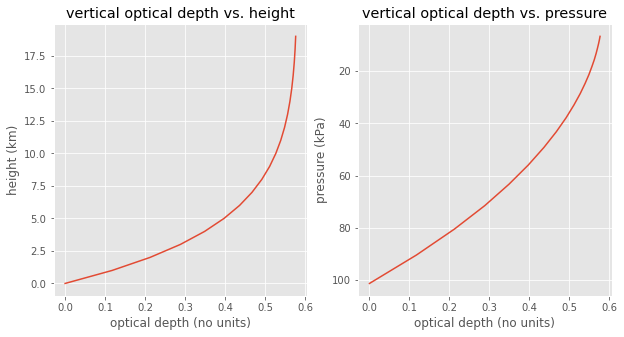

In [4]:
%matplotlib inline
plt.style.use("ggplot")
r_gas = 0.01  # kg/kg
k_lambda = 0.01  # m^2/kg
df = sound_dict["tropics"]
top = 20.0e3
df = df.loc[df["z"] < top]
height = df["z"]
press = df["press"]
tau = find_tau(r_gas, k_lambda, df)
fig1, (axis1, axis2) = plt.subplots(1, 2, figsize=(10, 5))
axis1.plot(tau, height * 1.0e-3)
axis1.set_title("vertical optical depth vs. height")
axis1.set_ylabel("height (km)")
axis1.set_xlabel("optical depth (no units)")
axis2.plot(tau, press * 1.0e-3)
axis2.invert_yaxis()
axis2.set_title("vertical optical depth vs. pressure")
axis2.set_ylabel("pressure (kPa)")
axis2.set_xlabel("optical depth (no units)")

## Plotting the weighting functions

Now we're ready to calculate the weighting functions $\Delta \hat{t}$ for different values of $k_\lambda$

This cell finds 7 wavenumbers ($1/\lambda$) in the CO2 absorption band between 666 and 766 $cm^{-1}$
It makes a list of both the wavenumbers and the $k_\lambda$ for each wavenumber, as well
as legend labels to use in plotting.

In [5]:
r_gas = 0.01  # kg/kg
#
# assign the 7 k_lambdas to 7 CO2 absorption band wavelengths
# (see Wallace and Hobbs figure 4.33)
#
wavenums = np.linspace(666, 766, 7)  # wavenumbers in cm^{-1}
wavelengths = 1 / wavenums * 1.0e-2  # wavelength in m
wavelengths_um = wavelengths * 1.0e6  # in microns
print("channel wavelengths (microns) ", wavelengths_um)  # microns
df = sound_dict["tropics"]
top = 20.0e3  # stop at 20 km
df = df.loc[df["z"] < top]
height = df["z"].values
mid_height = (height[1:] - height[:-1]) / 2.0
#
# here are the mass absorption coefficients for each of the 7 wavelengths
# in m^2/kg
#
k_lambda_list = np.array([0.175, 0.15, 0.125, 0.1, 0.075, 0.05, 0.025])
legend_string = [f"{item:5.3f}" for item in k_lambda_list]

channel wavelengths (microns)  [15.01501502 14.6484375  14.2993327  13.96648045 13.64877161 13.34519573
 13.05483029]


**The next cell finds the transmissivity $\hat{t}$ from $\tau$ (line 28) and calculates the
weighting function $\Delta \hat{t}$ using np.diff (line 30)**

Note that on line 28 we are defining the transmittance from the satellite to the surface, that is,
the transmittance = 1 at the top of the atmosphere where tau=tau_tot

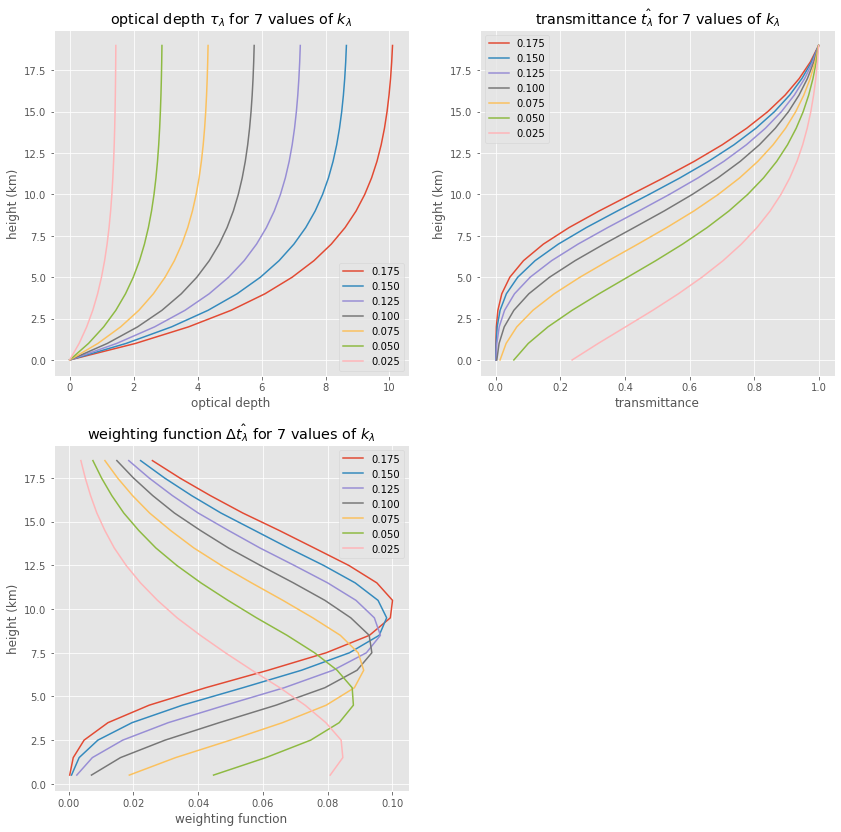

In [6]:
#
# make a list of tuples of k_lambda and its label
# using zip
#
k_vals = zip(k_lambda_list, legend_string)
#
#  find the height at mid-layer
#
mid_height = (height[1:] + height[:-1]) / 2.0
fig1, axis_list = plt.subplots(2, 2, figsize=(14, 14))
#
# turn axis_list from 2 x 2 to 4 x 1
#
axis_list = np.array(axis_list).ravel()
#
# throw away the 4th plot using delaxes -- only plotting 3 graphs
#
fig1.delaxes(axis_list[3])
axis_list = axis_list[:3]
for the_ax in axis_list:
    the_ax.grid(True)
heightkm = height * 1.0e-3
mid_heightkm = mid_height * 1.0e-3
for k_lambda, k_label in k_vals:
    tau = find_tau(r_gas, k_lambda, df)
    tau_tot = tau[-1]
    axis_list[0].plot(tau, heightkm, label=k_label)
    trans = np.exp(-(tau_tot - tau))
    axis_list[1].plot(trans, heightkm, label=k_label)
    del_trans = np.diff(trans)
    axis_list[2].plot(del_trans, mid_heightkm, label=k_label)

titles = [
    r"optical depth $\tau_{\lambda}$ for 7 values of $k_\lambda$",
    "transmittance $\hat{t_\lambda}$ for 7 values of $k_\lambda$",
    "weighting function $\Delta \hat{t_\lambda}$ for 7 values of $k_\lambda$",
]
xlabels = ["optical depth", "transmittance", "weighting function"]
for axis, title, xlabel in zip(axis_list, titles, xlabels):
    axis.set(title=title, xlabel=xlabel)
[axis.set_ylabel("height (km)") for axis in axis_list]
[axis.legend(loc="best") for axis in axis_list]
fig1.savefig("trans_plots.png")

## Integrating the Schwartzchild equation

This final cell uses the weighting functions to integrate the Schwartchild equation (Stull 8.4)

The weighting function is calculated at line 14, and the integral is done at line 15

For plotting the radiances are turned into brightness temperatures at line 17

[15.01501502 14.6484375  14.2993327  13.96648045 13.64877161 13.34519573
 13.05483029]


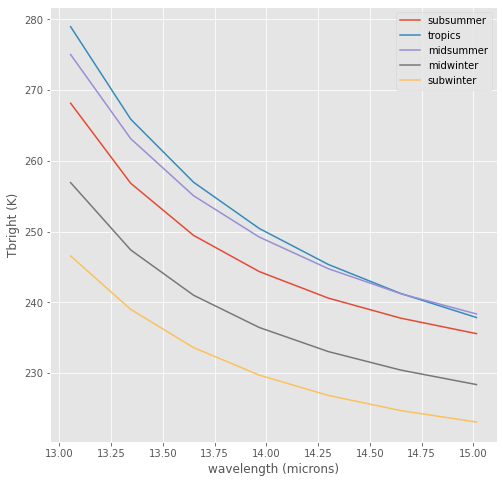

In [7]:
from collections import defaultdict
from sat_lib.radiation import calc_radiance, planck_invert

Tbright = defaultdict(list)
for the_sound, the_df in sound_dict.items():
    for the_wave_m, the_k in zip(wavelengths, k_lambda_list):
        #pdb.set_trace()
        tau = find_tau(r_gas, the_k, the_df)
        tau_tot = tau[-1]
        temps = the_df["temp"].values
        Bsfc = calc_radiance(the_wave_m, temps[0])
        sfc_contrib = Bsfc * np.exp(-tau_tot)
        mid_temps = (temps[1:] + temps[:-1]) / 2.0
        Batm = calc_radiance(the_wave_m, mid_temps)
        trans = np.exp(-(tau_tot - tau))
        weights = np.diff(trans)
        atm_contrib = np.sum(Batm * weights)
        Lsat = sfc_contrib + atm_contrib
        the_temp = planck_invert(the_wave_m, Lsat)
        Tbright[the_sound].append(the_temp)
    Tbright[the_sound] = np.array(Tbright[the_sound])

plt.style.use("ggplot")
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
the_wave_um = wavelengths * 1.0e6
for the_sound, the_temps in Tbright.items():
    ax.plot(the_wave_um, the_temps, label=the_sound)
ax.legend(loc="best")
ax.set(ylabel="Tbright (K)", xlabel="wavelength (microns)")
print(the_wave_um)